# Compare Runs
Compare different configurations for models

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
from ase import units
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
data_hash = '4380cfde'

## Pull Runs from MLFlow
ML flow uses local storage in the `mlruns` directory

In [3]:
def gather_run_summaries() -> list[dict]:
    """Get all runs for a certain experiment
    
    Pulls the metrics, parameters, tags, and the artifact URI (so we can download data later).
    
    Returns:
        List of dictionaries describing each run
    """
    
    output = []
    for path in Path('runs').rglob('performance.json'):
        path = path.parent

        # Load the input parameters
        date, run_hash = path.name.rsplit("-", 1)
        record = {
            'path': path,
            'hash': run_hash,
            'date': datetime.fromisoformat(date)
        }
        with open(path / 'params.json') as fp:
            for key, val in json.load(fp).items():
                record[f'param.{key}'] = val

        # Load in performance
        with open(path / 'performance.json') as fp:
            for key, val in json.load(fp).items():
                record[f'metric.{key}'] = val
        
        output.append(record)
        
    return output

In [4]:
summary = pd.DataFrame(gather_run_summaries()).sort_values('date')
summary.tail()

,path,hash,date,param.train_files,param.test_files,param.val_frac,param.num_epochs,param.batch_size,param.learning_rate,param.loss_weights,...,param.test_size,param.cuda_version,param.device_name,param.host,metric.train_time,metric.eval_time,metric.energy_mae,metric.force_mean_error,metric.force_max_error,metric.stress_mae
0,runs/2024-07-26T10:36:04.320217-2ad49c23,2ad49c23,2024-07-26 10:36:04.320217,[../../../aimd-with-actinides/0_setup/md/packm...,[../../../aimd-with-actinides/0_setup/md/packm...,0.1,32,8,0.0001,"[1, 10, 100]",...,2048,12.1,NVIDIA GeForce RTX 3070 Ti,bettik-linux,105.714411,0.005660,0.003519,0.178834,2.465392,0.000426
1,runs/2024-07-26T11:51:11.036161-2066ebc3,2066ebc3,2024-07-26 11:51:11.036161,[../../../aimd-with-actinides/0_setup/md/packm...,[../../../aimd-with-actinides/0_setup/md/packm...,0.1,32,8,0.0001,"[1, 10, 100]",...,2048,12.1,NVIDIA GeForce RTX 3070 Ti,bettik-linux,106.683144,0.006047,0.009610,0.195417,2.512392,0.000802
4,runs/2024-07-26T12:49:45.223900-09589277,09589277,2024-07-26 12:49:45.223900,[../../../aimd-with-actinides/0_setup/md/packm...,[../../../aimd-with-actinides/0_setup/md/packm...,0.1,32,8,0.0001,"[1, 10, 100]",...,2048,12.1,NVIDIA GeForce RTX 3070 Ti,bettik-linux,114.158978,0.006974,0.024344,0.175003,2.539566,0.001652
3,runs/2024-07-26T13:55:45.483095-c338c5d4,c338c5d4,2024-07-26 13:55:45.483095,[../../../aimd-with-actinides/0_setup/md/packm...,[../../../aimd-with-actinides/0_setup/md/packm...,0.1,2,8,0.0001,"[1, 10, 100]",...,2048,12.1,NVIDIA GeForce RTX 3070 Ti,bettik-linux,124.218006,0.006178,0.004438,0.300883,2.530510,0.001066
2,runs/20240726T140122-cfc18061,cfc18061,2024-07-26 14:01:22.000000,[../../../aimd-with-actinides/0_setup/md/packm...,[../../../aimd-with-actinides/0_setup/md/packm...,0.1,64,8,0.0001,"[1, 10, 100]",...,2048,12.1,NVIDIA GeForce RTX 3070 Ti,bettik-linux,112.833494,0.006059,0.003718,0.164992,2.521154,0.000544


## Evaluate Best Model
See how the model's error wrt frame appears and learning curve during training

In [5]:
top_runs = summary[summary['param.test_hash'] == data_hash]
best_run = top_runs.sort_values('metric.force_mean_error', ascending=True).iloc[0]

Pull out the parameters

In [6]:
params = dict((k[6:], v) for k, v in best_run.to_dict().items() if k.startswith('param.'))
params

{'train_files': ['../../../aimd-with-actinides/0_setup/md/packmol-uo2_nitrate-waters=64-seed=2-blyp-npt=298/md.traj',
  '../../../aimd-with-actinides/0_setup/md/packmol-uo2_nitrate-waters=64-seed=3-blyp-npt=298/md.traj',
  '../../../aimd-with-actinides/0_setup/md/packmol-uo2_nitrate-waters=64-seed=4-blyp-npt=298/md.traj'],
 'test_files': ['../../../aimd-with-actinides/0_setup/md/packmol-uo2_nitrate-waters=64-seed=1-blyp-npt=298/md.traj'],
 'val_frac': 0.1,
 'num_epochs': 64,
 'batch_size': 8,
 'learning_rate': 0.0001,
 'loss_weights': [1, 10, 100],
 'scale_energies': True,
 'hidden_layers': 2,
 'hidden_units': 128,
 'hidden_decay': 0.8,
 'radial_cutoff': 5.2,
 'angular_cutoff': 3.5,
 'radial_eta': 16,
 'angular_eta': 8,
 'angular_zeta': 8,
 'num_radial_terms': 16,
 'num_angular_dist_terms': 4,
 'num_angular_angl_terms': 8,
 'train_hash': 'ce67dc79',
 'train_size': 5532,
 'valid_size': 612,
 'test_hash': '4380cfde',
 'test_size': 2048,
 'cuda_version': '12.1',
 'device_name': 'NVIDIA Ge

Plot the error as a function of timestep

In [7]:
preds = np.load(best_run['path'] / 'test_pred.npz')

In [8]:
true = np.load(best_run['path'] / 'test_true.npz')

Predicted vs actual

In [9]:
pred_e_pera = preds['energy'] / preds['count']
true_e_pera = true['energy'] / true['count']
for pera in [pred_e_pera, true_e_pera]:
    pera -= true_e_pera.min()
    pera *= 1000

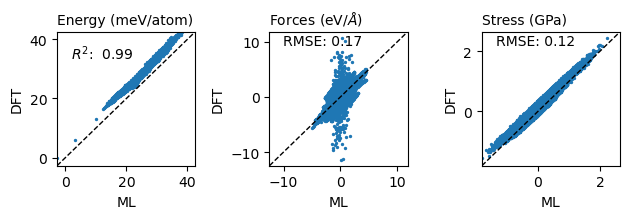

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(6.4, 2.3))

ax = axs[0]
ax.scatter(pred_e_pera, true_e_pera, s=2)
lim = [
    min(pred_e_pera.min(), true_e_pera.min()),
    max(pred_e_pera.max(), true_e_pera.max())
]
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

r2_score = np.corrcoef(pred_e_pera, true_e_pera)[0, 1]
ax.text(0.1, 0.8, f'$R^2$: {r2_score: .2f}', transform=ax.transAxes, fontsize=10)

ax.set_title('Energy (meV/atom)', loc='left', fontsize=10)

ax = axs[1]
ax.scatter(preds['forces'].flatten(), true['forces'].flatten(), s=2)
ax.set_title('Forces (eV/$\\AA$)', loc='left', fontsize=10)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

rmse = np.sqrt(np.power(preds['forces'].flatten() - true['forces'].flatten(), 2).mean())
ax.text(0.1, 0.9, f'RMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=10)


ax = axs[2]
ax.scatter(preds['stress'] / units.GPa, true['stress'] / units.GPa, s=2)
ax.set_title('Stress (GPa)', loc='left', fontsize=10)

rmse = np.sqrt(np.power(preds['stress'] - true['stress'], 2).mean()) / units.GPa
ax.text(0.1, 0.9, f'RMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=10)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

for ax in axs:
    ax.set_xlabel('ML')
    ax.set_ylabel('DFT')

fig.tight_layout()

Plot the training curve

In [11]:
train_log = pd.read_csv(best_run['path'] / "log.csv")

Text(0.5, 0, 'Epoch')

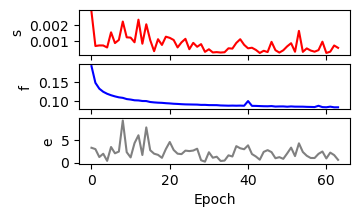

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 2.))

for a, c, color in zip(axs, ['s_rmse_valid', 'f_rmse_valid', 'e_rmse_valid'], ['red', 'blue', 'gray']):
    a.plot(train_log[c], color=color)
    a.set_ylabel(c.split("_")[0])
    a.set_label('Loss')

axs[-1].set_xlabel('Epoch')